# DSCI 100 Final Project

# Introduction

# Add introduction here  - pls edit

# Methods & Results

# add methods and results here - pls edit 

In [35]:
library(tidyverse)
library(repr)
library(tidymodels)

In [90]:
set.seed(1)

url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url_players)


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [91]:
players_select <- players|> 
          select(experience, age, played_hours)

In [92]:
# to make the exprience into ordinal data 
players_numerical <- players_select|>
                     mutate(experience_num = case_when(experience == "Veteran" ~ 5,
                                                       experience == "Pro" ~ 4,
                                                       experience == "Regular" ~ 3,
                                                       experience == "Amateur" ~ 2,
                                                       experience == "Beginner" ~ 1))|>
                    select(-experience)

# add analysis here - pls edit

In [94]:
#spilting 
players_split <- initial_split(players_numerical, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

# add analysis here - pls edit

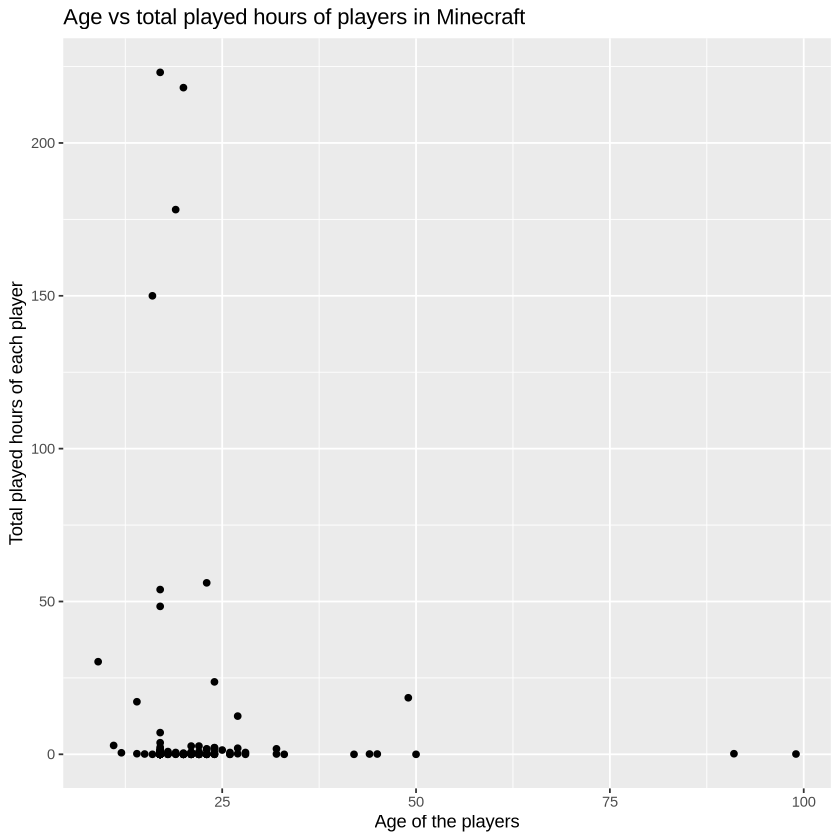

In [95]:
# exploratory plot of age vs played hours 
age_training_plot <- players_training|> 
                         ggplot(aes(x=age, 
                                    y=played_hours))+
                         geom_point()+
                         labs(x = "Age of the players",
                              y = "Total played hours of each player")+
                         ggtitle("Age vs total played hours of players in Minecraft")
age_training_plot 


# add analysis here -pls edit

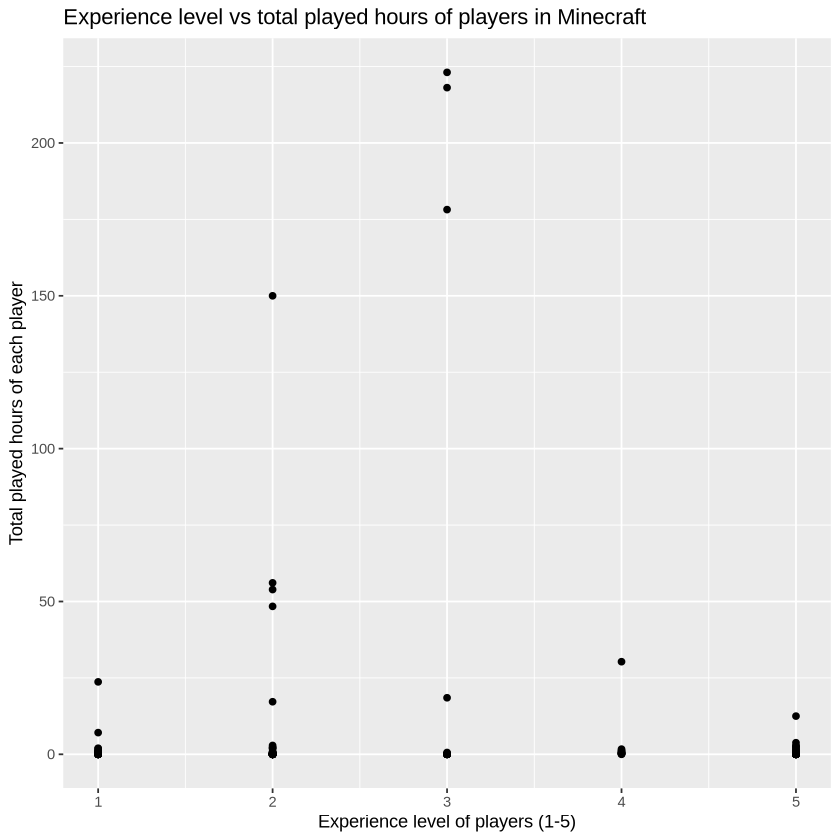

In [96]:
# exploratory plot of experience level vs played hours 
experience_training_plot <- players_training|> 
                         ggplot(aes(x=experience_num, 
                                    y=played_hours))+
                         geom_point()+
                         labs(x = "Experience level of players (1-5)",
                              y = "Total played hours of each player")+
                         ggtitle("Experience level vs total played hours of players in Minecraft")
experience_training_plot 


# add analysis here  - pls edit

In [97]:
# receipe for the knn regression

players_recipe <- recipe(played_hours ~ experience_num + age, data = players_training) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

# add analysis here - pls edit

In [99]:
# cross - validation using 5 folds
players_vfold <- vfold_cv(data = players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
                     add_recipe(players_recipe) |>
                     add_model(players_spec)


# add analysis here - pls edit

In [100]:
# testing to see which k neighbours would be best based on lowest rmse

gridvals <- tibble(neighbors = seq(from = 1, to = 85, by = 5))

players_results_min <- players_workflow |>
                       tune_grid(resamples = players_vfold, grid = gridvals)|> 
                       collect_metrics()|> 
                       filter(.metric == "rmse")|>
                       filter(mean == min(mean))
head(players_results_min)


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
26,rmse,standard,28.92636,5,6.99289,Preprocessor1_Model06


# add analysis here - pls edit

In [101]:
# testing with test data and find rmse

k_min <- players_results_min |>
         pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
                     set_engine("kknn") |>
                     set_mode("regression")

players_fit <- workflow() |>
               add_recipe(players_recipe) |>
               add_model(players_best_spec) |>
               fit(data = players_training)


players_summary <- players_fit |>
                   predict(players_testing) |>
                   bind_cols(players_testing) |>
                   metrics(truth = played_hours, estimate = .pred)|>
                   filter(.metric == "rmse")
players_summary


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,12.94653


# add analysis here - pls edit

.pred,age,played_hours,experience_num
<dbl>,<dbl>,<dbl>,<dbl>
0.3972222,17,0.0,5
18.6361111,21,0.1,3
8.7000000,17,0.1,2
0.6972222,22,0.0,5
0.3972222,17,0.0,5
3.2250000,17,0.0,1


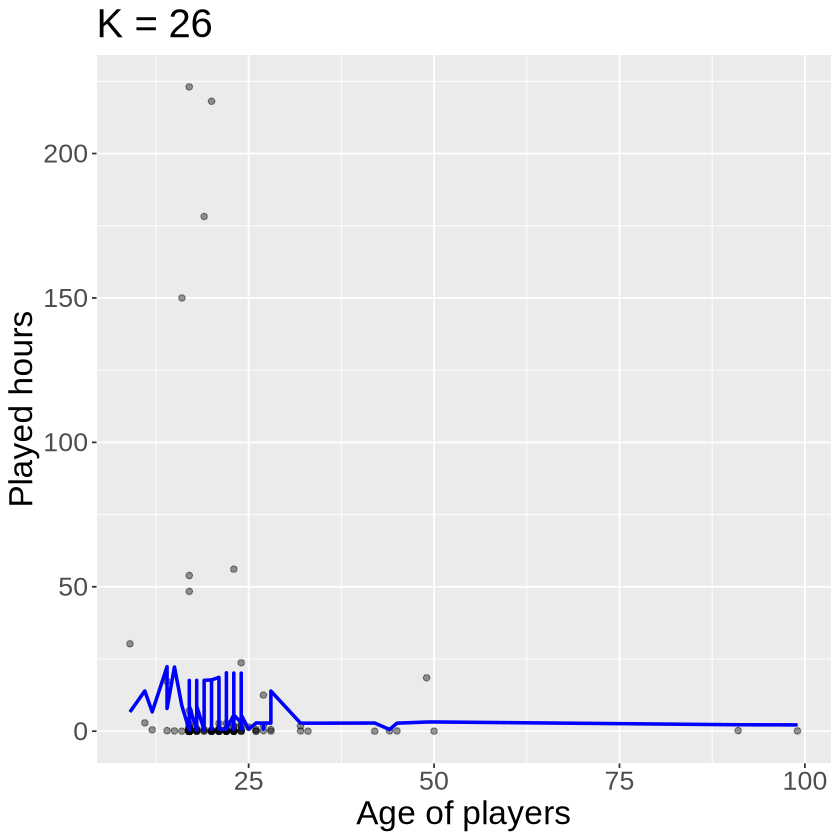

In [102]:
# visualizing the relationship between age and played hours with k = 36

players_preds <- players_best_fit |>
                 predict(players_training) |>
                 bind_cols(players_training)

head(players_preds)

players_plot <- ggplot(players_preds, aes(x = age, y = played_hours)) +
                geom_point(alpha = 0.4) +
                geom_line(data = players_preds,
                          mapping = aes(x = age, y = .pred),
                          color = "blue",
                          linewidth = 1) +
                xlab("Age of players") +
                ylab("Played hours") + 
                geom_line(data = players_preds, aes(x = age, y = .pred), color = "blue") +
                ggtitle(paste0("K = ", k_min)) +
                theme(text = element_text(size = 20))

players_plot

# add analysis here - pls edit

.pred,age,played_hours,experience_num
<dbl>,<dbl>,<dbl>,<dbl>
0.3972222,17,0.0,5
18.6361111,21,0.1,3
8.7000000,17,0.1,2
0.6972222,22,0.0,5
0.3972222,17,0.0,5
3.2250000,17,0.0,1


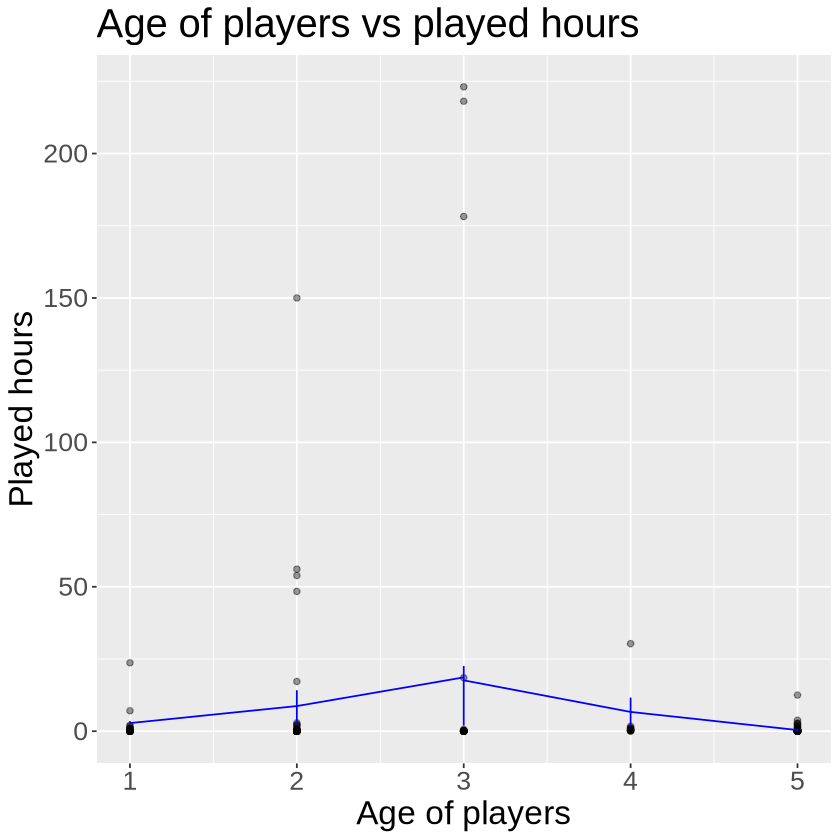

In [103]:
# visualizing the relationship between age and played hours
players_preds <- players_best_fit |>
                predict(players_training) |>
                bind_cols(players_training)

head(players_preds)

players_plot <- ggplot(players_preds, aes(x = experience_num, y = played_hours)) +
                geom_point(alpha = 0.4) +
                xlab("Age of players") +
                ylab("Played hours") + 
                geom_line(data = players_preds, aes(x = experience_num, y = .pred), color = "blue") +
                ggtitle("Age of players vs played hours") +
                theme(text = element_text(size = 20))

players_plot

# add anaylsis here - pls edit 